In [16]:
import sys
import os

sys.path.append(os.path.abspath(".."))

# 1. Dataset Introduction & Loading

The dataset `short_seasonal.csv` is a synthetic dataset, data generation code can be found in `src/synthetic_data_generation.ipynb`. It is a small dataset of 80 data points and simulates monthly data with strong seasonality and a positive linear trend. 

The purpose of this dataset is to provide a small, computationally efficient dataset to test upon. It's short length and strong seasonality also brings unique challenges to data-intensive models with less seasonality adaptions.

### Loading data from `csv`

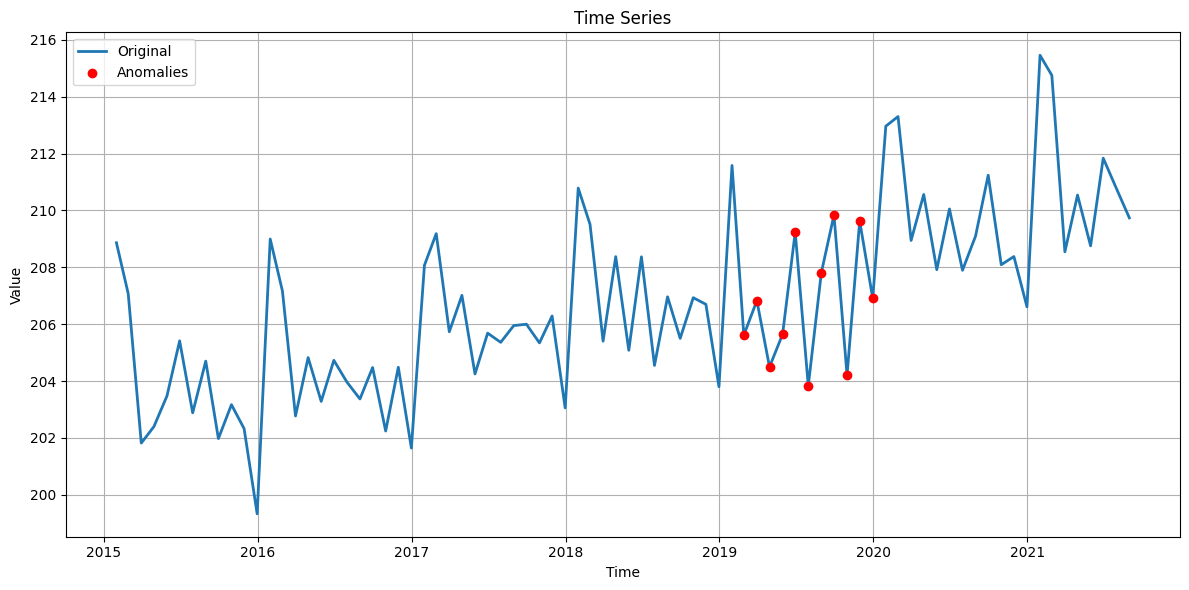

In [17]:
import pandas as pd
from src.synthetic_data.synthetic_data_tools import load_synthetic_data
from src.visualization.plots import plot_ts

data_file = '../data/short_seasonal.csv'

data, ts, lables = load_synthetic_data(data_file)
plot_ts(ts, anom=lables)

This time series is generated additive model, using a linear trend, period 12 seasonality, and $MA(1)$ noise.

The anomalies for this dataset occur from Feb 2019 to Dec 2019. The anomaly values are generated using independent sampling from a normal distribution with `mean=ts.mean()` and `std=2.5`.

For the upcoming modeling sections, I will be working only with the original time series **without** the labels. The goal of this report is to investigate how well models detect anomalies on **unlabeled** data.

# 2. Modeling - Classical Statistics

To begin, lets plot the time series to gain an overall understanding of it.

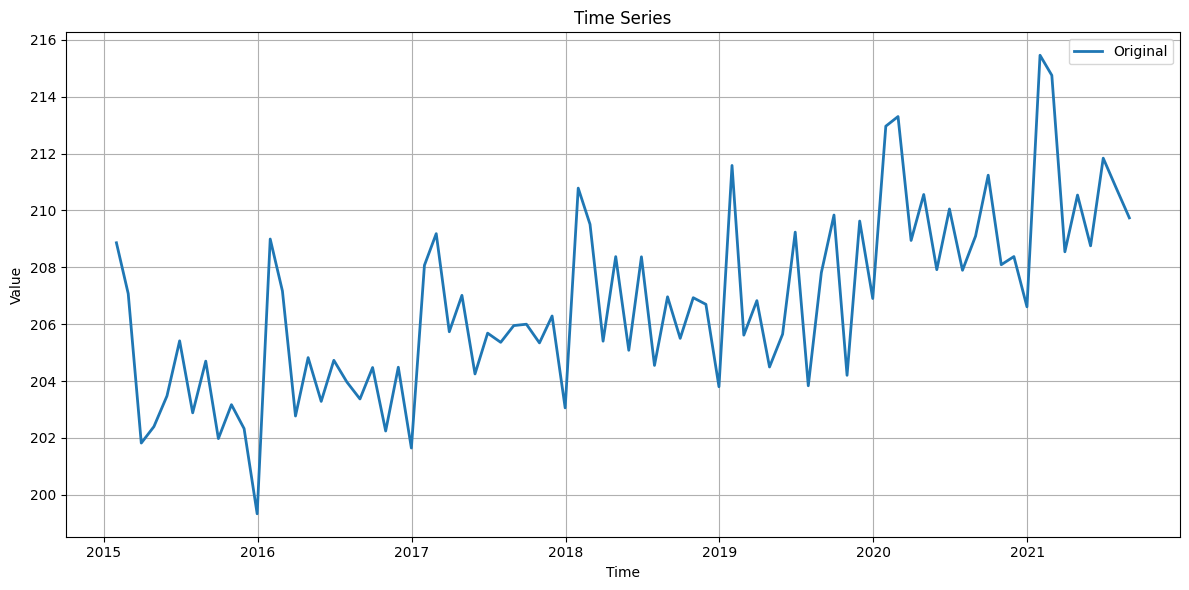

In [18]:
plot_ts(ts)

Observations:
- Strong yearly seasonality, values peek during the first 1-2 months every year
- Increasing trend, seems roughly linear

## STL Model

To begin, lets start with a quick Seasonal-Trend decomposition.

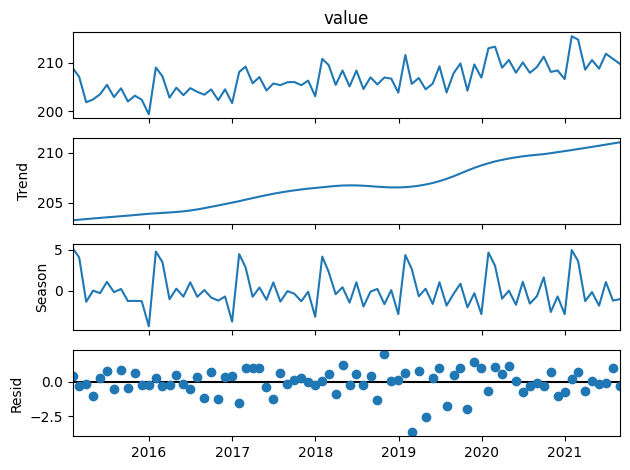

In [19]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=12) 
stl_result = stl.fit()

_ = stl_result.plot()

Observations:
- Mostly linear trend with a light wave shape from 2017-2020
- Larger residuals from late 2018 to late 2019

### Investigation: Linear Trend

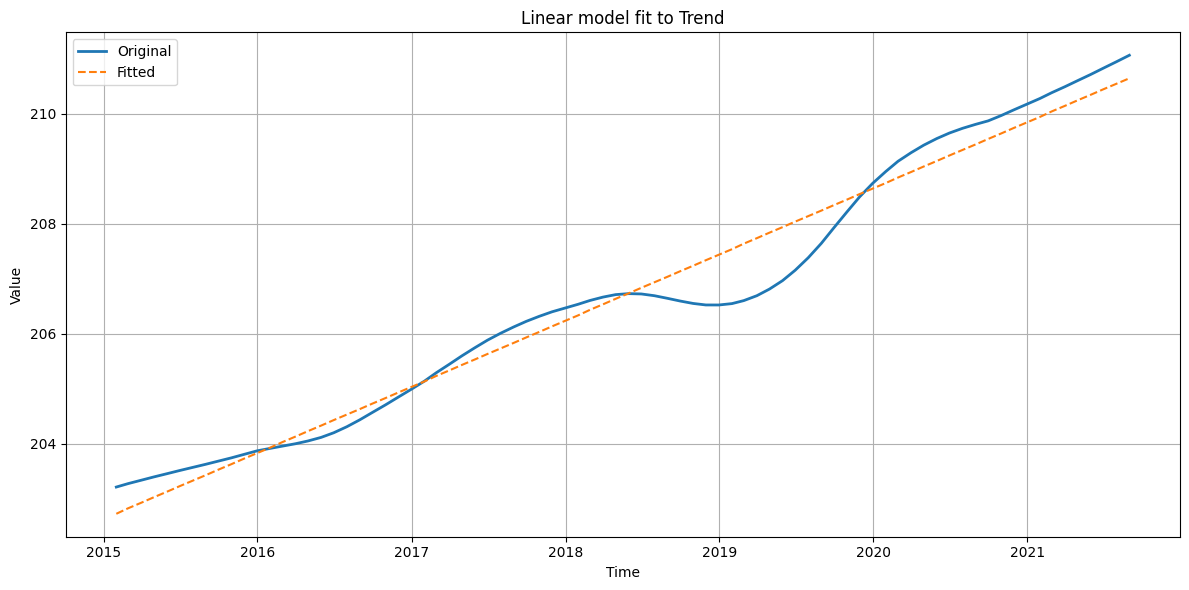

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2357.
Date:                Fri, 01 Aug 2025   Prob (F-statistic):           4.80e-60
Time:                        09:59:05   Log-Likelihood:                -44.321
No. Observations:                  80   AIC:                             92.64
Df Residuals:                      78   BIC:                             97.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        202.7235      0.094   2145.908      0.0

In [20]:
from src.models.statistical.linear_models import linear_model

lin_model, X = linear_model(stl_result.trend)
lin_results = lin_model.fit()

plot_ts(stl_result.trend, fit=pd.Series(lin_results.predict(X), index=ts.index), title='Linear model fit to Trend')
print(lin_results.summary())

The summary provides evidence that trend should be modeled linearly. With a $p$-value of $0.000$ for all parameters, there is strong evidence against any model parameters being zero, hence no need to drop parameters. The R-squared and Adj. R-squared are both high at $0.968$, showing $96.8\%$ of the response can be explained by the explanatory variables

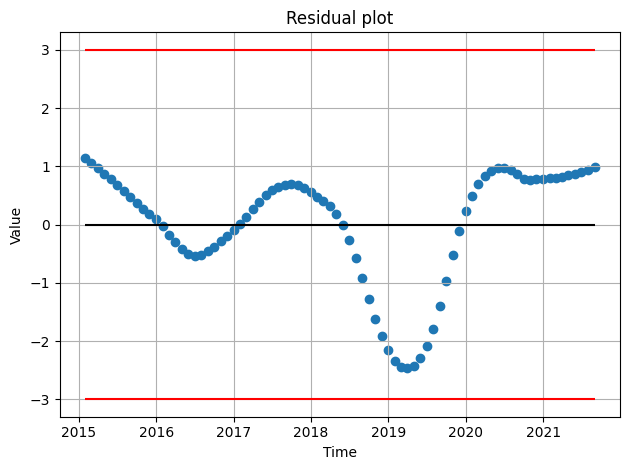

In [21]:
from src.visualization.plots import plot_scatter
from src.models.preprocessing import standardize_residuals

lin_resid = standardize_residuals(pd.Series(lin_results.resid, index=ts.index))
plot_scatter(lin_resid, hlines=[-3, 3])

There is strong trend in the residual plot suggesting that the residuals are not indenpent and identiacally distributed normal. The original time series deviates futhest from the preditions from late 2018 to late 2019.

### Investigation: Residuals

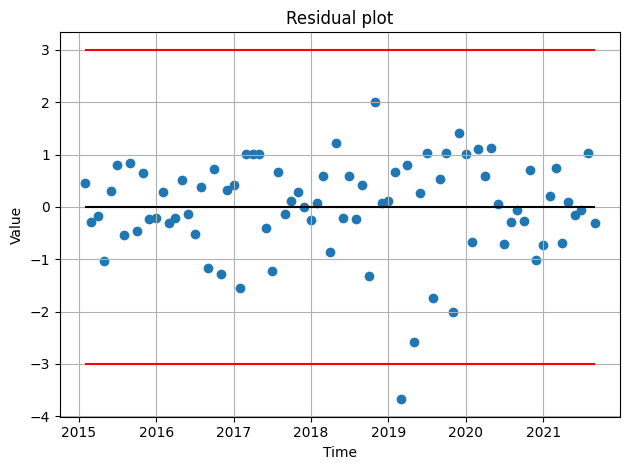

In [22]:
stl_resid = standardize_residuals(pd.Series(stl_result.resid, index=ts.index))
plot_scatter(stl_result.resid, hlines=[-3, 3])

The residuals look independent and evenly spread across zero, with outliers occuring between mid 2018 and late 2019.

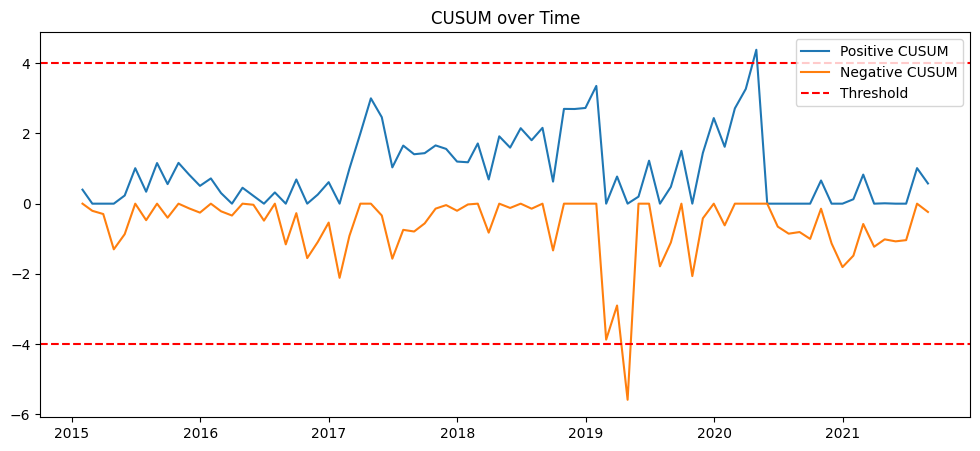

In [23]:
from src.models.statistical.rule_based import cusum

stl_cusum_anoms = cusum(stl_resid, plot=True)

No significant anomaly clusters are found by running CUSUM on the residuals, showing little change in mean of the residuals.

## SARIMA Model
### Differenced Time Series

Base on part 2.1, it is safe to assume that there is a seasonal component of period 12 and a linear trend.

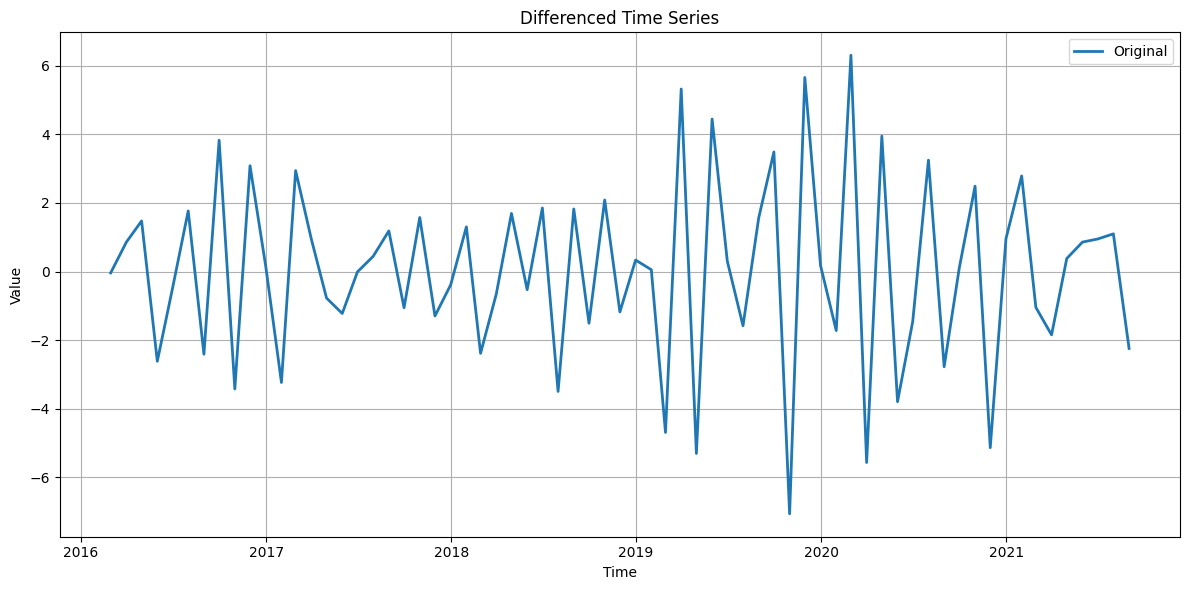

In [24]:
ts_diff = ts.diff(12).diff()
plot_ts(ts_diff, title='Differenced Time Series')

Differencing the time series first by the period (to remove seasonalitiy) then by 1-step back in time give the above graph. This differenced times series looks to have constant mean around zero, but with variablilty in variance.

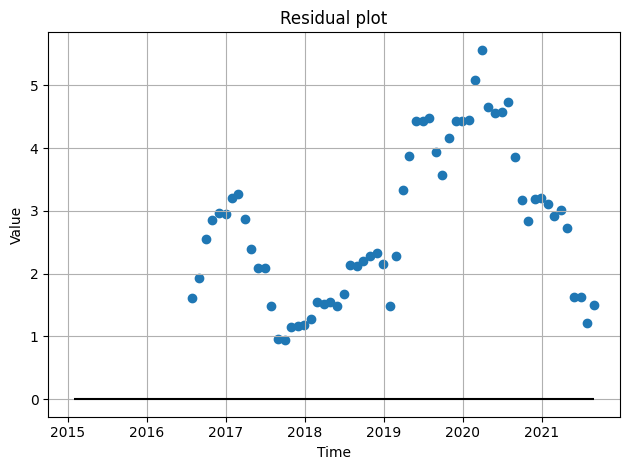

In [25]:
from src.models.statistical.rule_based import rolling_variance
from src.visualization.plots import plot_scatter

window_size = 6
rolling_var = rolling_variance(ts_diff, window=window_size)
plot_scatter(rolling_var)

In [26]:
from statsmodels.stats.diagnostic import het_arch

arch_stat, pval, _, _ = het_arch(ts_diff.dropna(), nlags=6)
print(f"ARCH test p-value: {pval}")

ARCH test p-value: 0.0023997046998173567


The $p$-value for the ARCH test is statisically significant, showing there is strong evidence that heteroskedasticity exists in the time series 

In [27]:
from statsmodels.tsa.stattools import adfuller

stationary_pval = adfuller(ts_diff.dropna())[1]
print(f'p-value: {stationary_pval}')

p-value: 4.836028218025845e-23


Applying the augmented Dickey–Fuller test on the differenced time series returns a statistically significant $p$-value, thus there is strong evidence that the time series is stationary (constant mean and variance).

### SARIMA Model selection

Lets begin by plotting the acf/pacf values to get an idea of the auto-correlation for this times series.

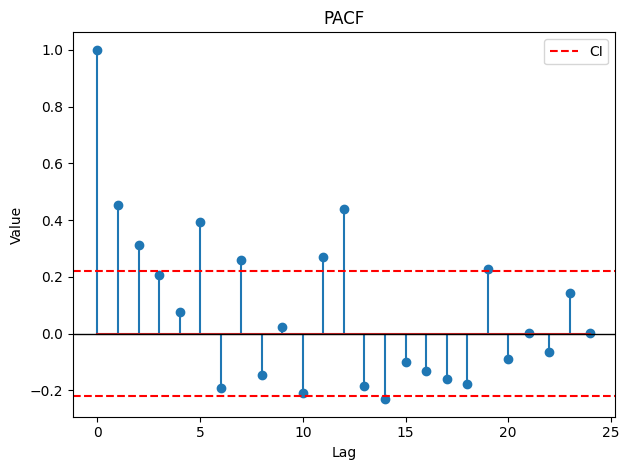

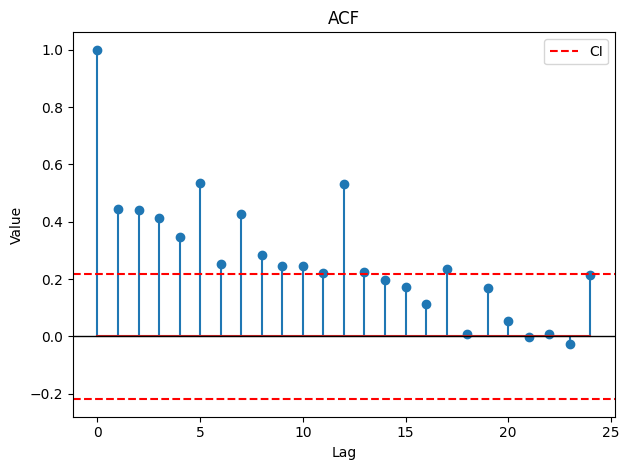

In [28]:
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import norm
from src.visualization.plots import plot_lag_with_ci
import numpy as np

nlags = 24 # Covers 2 periods
pacf_vals = pacf(ts, nlags=nlags)
acf_vals = acf(ts, nlags=nlags, fft=True)

conf_interval = norm.ppf(1 - 0.05 / 2) / np.sqrt(len(ts))
plot_lag_with_ci(pacf_vals, conf_interval, title='PACF')
plot_lag_with_ci(acf_vals, conf_interval, title='ACF')

Both the ACF and PACF plots have a notably high lag at $12$, suggesting $(P, D, Q)=(1, 1, 1)$. 

The ACF and PACF both seem to be deminished in value over higher lags, but have many statistically significant lags in the first period $(< 12)$. This may be due to small data sample size (total length of $80$ and post-differencing lenght of $67$). For simplicity, only $p, q < 3$ are considered.

In [29]:
from src.models.statistical.arma_models import SARIMA_grid_search

results_table = SARIMA_grid_search(ts, period=12, d=1, D=1, max_p=3, max_q=3, max_P=1, max_Q=1)
df_results = pd.DataFrame(results_table).sort_values('AIC', na_position='last')

display(df_results[['order', 'seasonal_order', 'AIC', 'BIC']].head(10))

,order,seasonal_order,AIC,BIC
41,"(2, 1, 2)","(0, 1, 1, 12)",259.253896,272.482051
9,"(0, 1, 2)","(0, 1, 1, 12)",260.036414,268.855184
21,"(1, 1, 1)","(0, 1, 1, 12)",260.078275,268.897045
5,"(0, 1, 1)","(0, 1, 1, 12)",260.425185,267.039263
45,"(2, 1, 3)","(0, 1, 1, 12)",260.611686,276.044534
29,"(1, 1, 3)","(0, 1, 1, 12)",260.637314,273.865470
43,"(2, 1, 2)","(1, 1, 1, 12)",260.907050,276.339898
57,"(3, 1, 2)","(0, 1, 1, 12)",261.001091,276.433939
53,"(3, 1, 1)","(0, 1, 1, 12)",261.168926,274.397082
37,"(2, 1, 1)","(0, 1, 1, 12)",261.690080,272.713543


The top 10 models show no significant difference in their `aic` or `bic` scores. Taking both metrics and model complexcity into consideration, I have choosen $SARIMA(0, 1, 1)(0, 1, 1, 12)$ to be the model for further analysis.

The choosen model is plotted below.

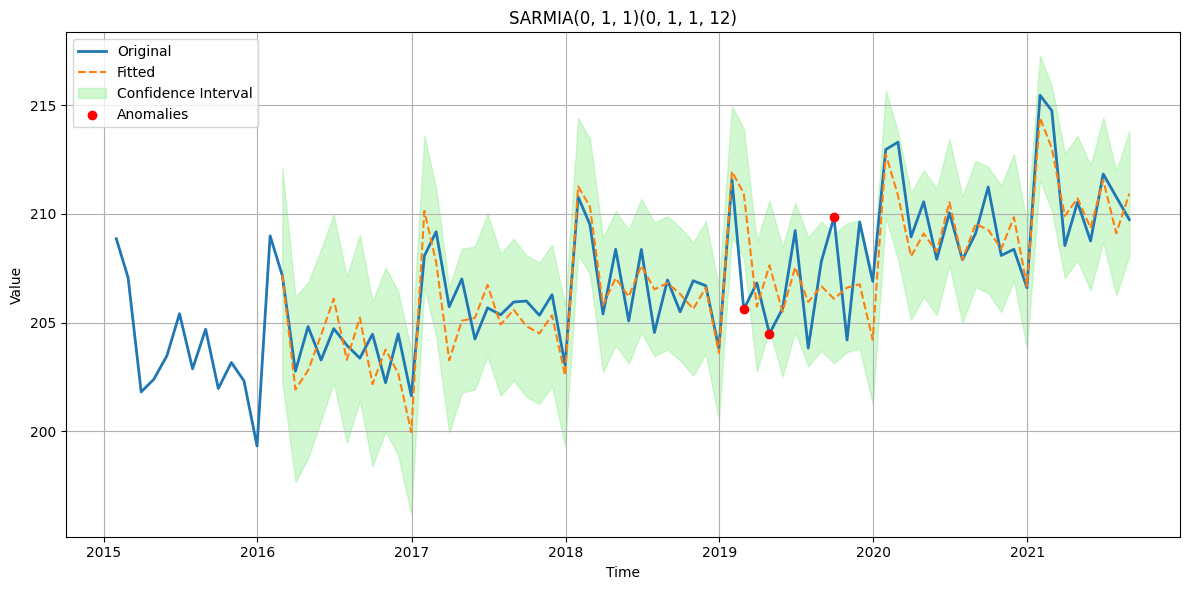

In [30]:
best_sarima_model = df_results.iloc[3]
plot_ts(ts, fit=best_sarima_model['model'].fittedvalues[13:], CI=best_sarima_model['conf_int'], anom=best_sarima_model['anom'], title=f'SARMIA{best_sarima_model['order']}{best_sarima_model['seasonal_order']}')

### SARIMA residual analysis

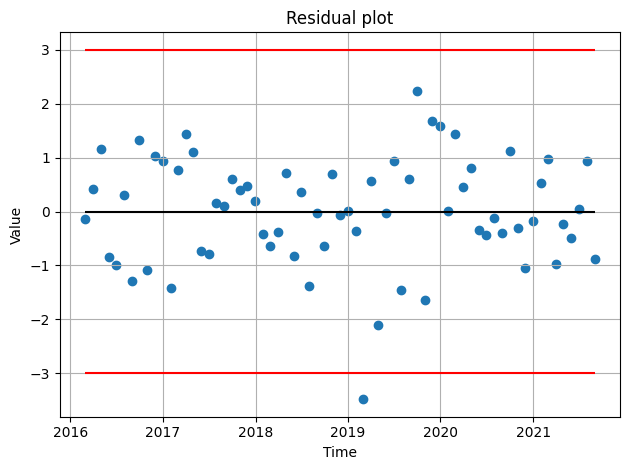

In [31]:
from src.models.preprocessing import standardize_residuals

sarima_resid = standardize_residuals(best_sarima_model['model'].resid[13:])
plot_scatter(sarima_resid, hlines=[-3, 3])

### Across model Anomalies

Going back to all the SARIMA models fitted during the grid search, we can look at the data points where all models had a hard time predicting

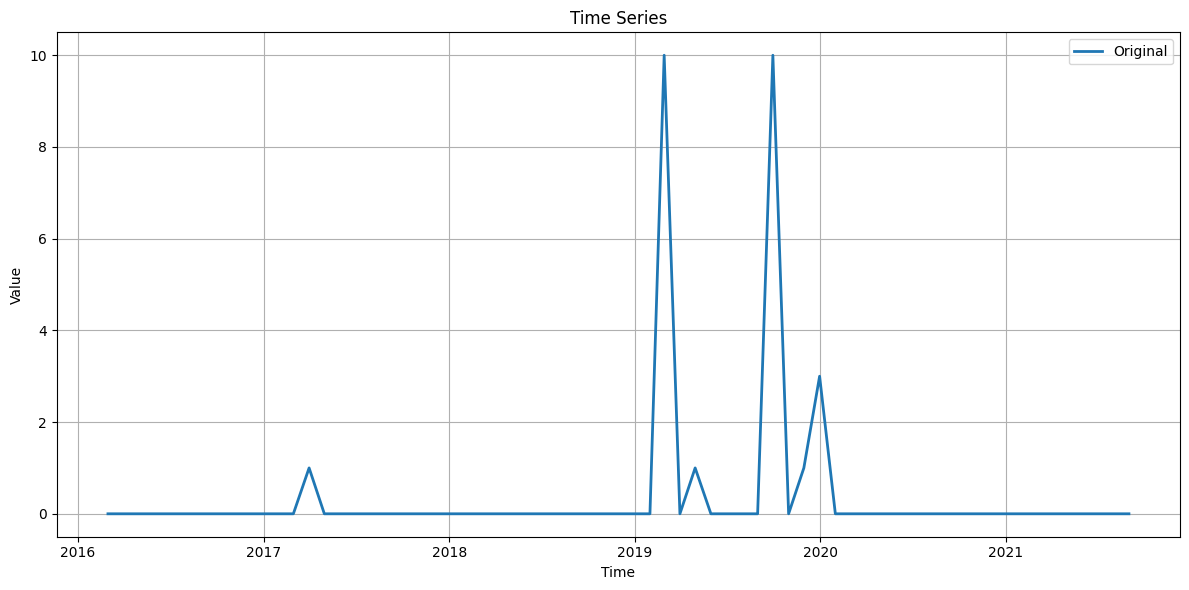

In [32]:
from src.models.statistical.arma_models import count_anoms

anom_counts = count_anoms(df_results[['anom']].head(10))
plot_ts(anom_counts)

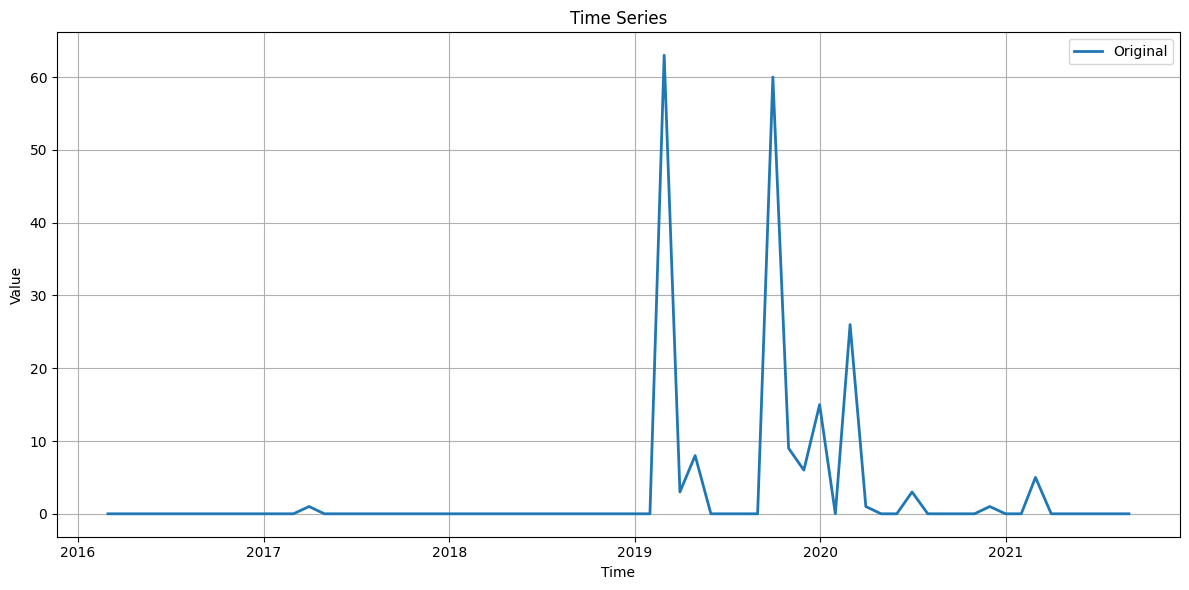

In [33]:
anom_counts = count_anoms(df_results[['anom']])
plot_ts(anom_counts)

This shows that models have a significatly harder time predicting data points from early 2019 to early 2020

# 3 Self Trained Machine Learning models

Add Isolation forest and TCN

## LSTM Autoencoder

In [34]:
import torch
from src.models.preprocessing import standardize_ts, create_sliding_windows, np_to_dataloader

g = torch.Generator()
g.manual_seed(13)

windows = create_sliding_windows(standardize_ts(ts), window_size=12)
data_loader = np_to_dataloader(windows, batch_size=16, generator=g)

ImportError: cannot import name 'standardize_ts' from 'src.models.preprocessing' (c:\Users\tangj\project\time_series_anomaly\src\models\preprocessing.py)

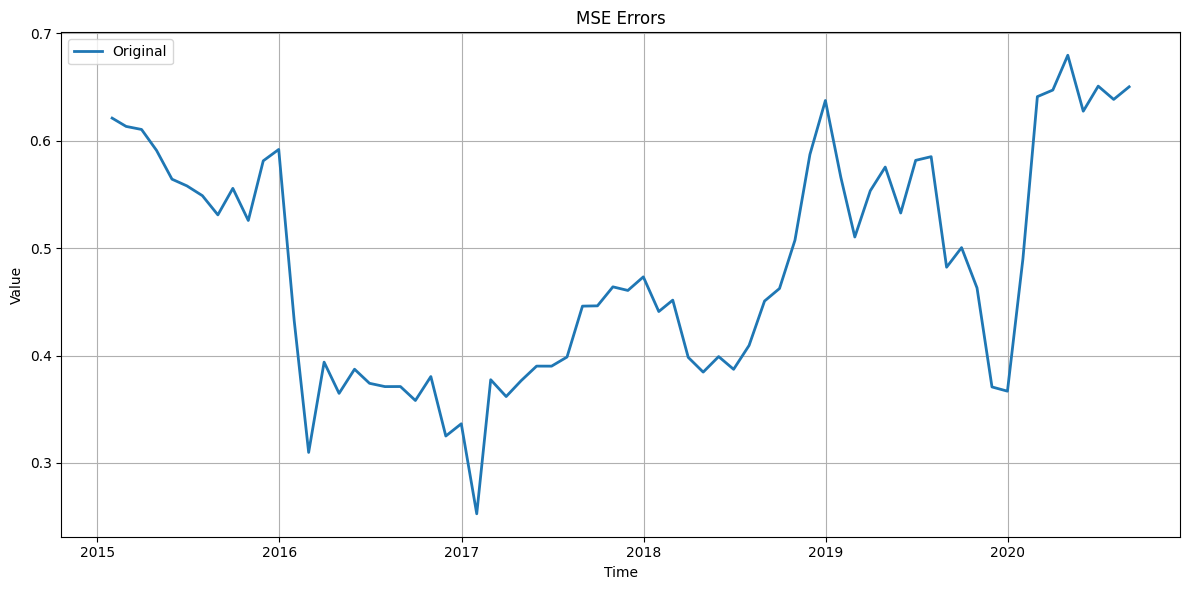

In [ ]:
from src.models.self_trained_ml.lstm_ae import LSTMAutoencoder
from src.models.self_trained_ml.lstm_ae import train_LSTMAE, eval_LTSMAE
import torch
import torch.optim as optim
import torch.nn as nn

model = LSTMAutoencoder(hidden_dim=8, latent_dim=8)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

train_LSTMAE(model, data_loader, criterion=criterion, optimizer=optimizer, epochs=50)
mse_LSTM = eval_LTSMAE(model, test_data=torch.tensor(windows, dtype=torch.float32).unsqueeze(-1))

errors_ts = pd.Series(mse_LSTM.numpy(), index=ts.index[:len(ts)-12])
plot_ts(errors_ts, title='MSE Errors')

# 4 Pretrained Models

## 4.1 Prophet

c:\Users\tangj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:54:22 - cmdstanpy - INFO - Chain [1] start processing
09:54:23 - cmdstanpy - INFO - Chain [1] done processing


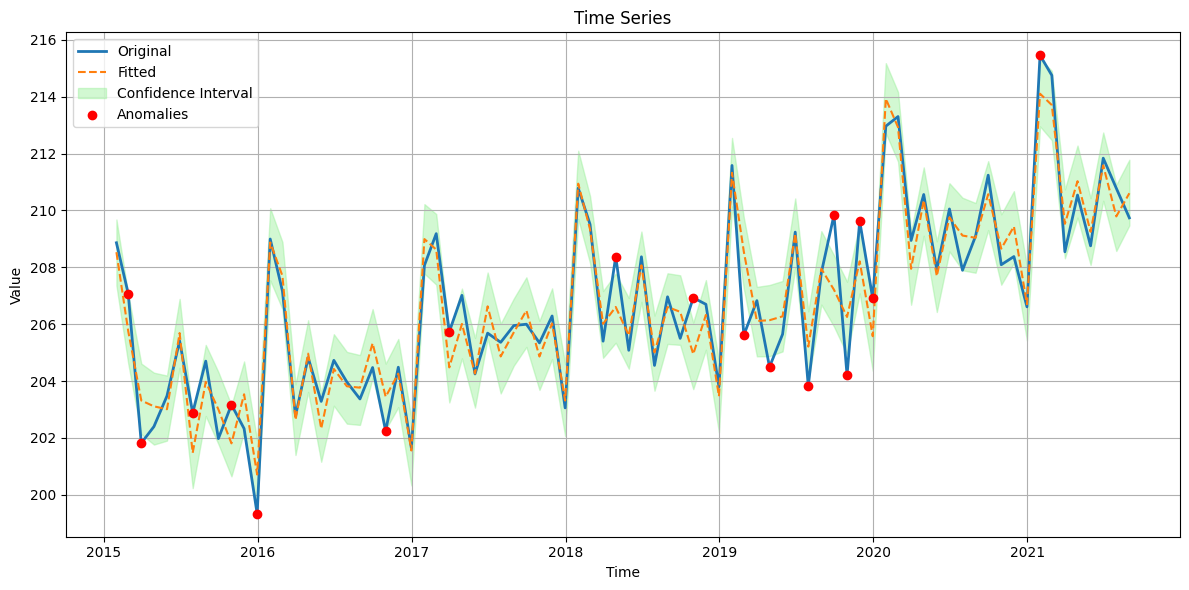

In [ ]:
from prophet import Prophet
from src.visualization.plots import plot_ts

prophet_df = pd.DataFrame({
    'ds': ts.index,  
    'y': ts.values 
})

model = Prophet()
model.fit(prophet_df)

prophet_pred = model.predict(prophet_df[['ds']].copy())

prophet_anom = (prophet_df['y'] < prophet_pred['yhat_lower']) | (prophet_df['y'] > prophet_pred['yhat_upper'])
prophet_anom = pd.Series(prophet_anom.values, index=ts.index)

prophet_CI = prophet_pred[['yhat_lower', 'yhat_upper']].copy()
prophet_CI.index = ts.index

plot_ts(ts, pd.Series(prophet_pred['yhat'].values, index=ts.index), CI=prophet_CI, anom=prophet_anom)

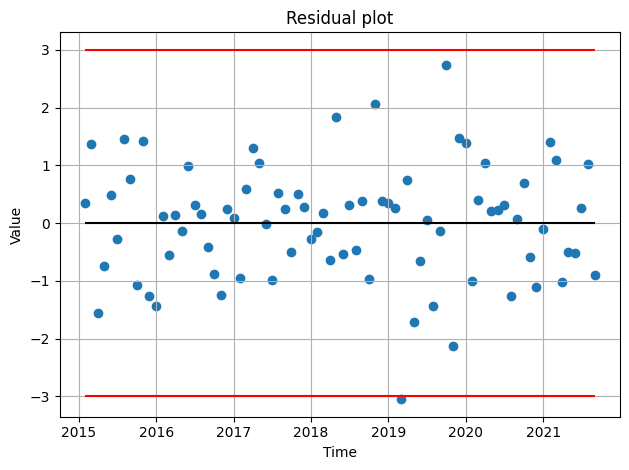

In [ ]:
from src.visualization.plots import plot_scatter
from src.models.preprocessing import standardize_residuals

prophet_resid = standardize_residuals(pd.Series(prophet_df['y'].values - prophet_pred['yhat'].values, index=ts.index))
plot_scatter(prophet_resid, hlines=[-3, 3])

## 4.2 AWS Lookout for Metrics

Due to the [data size and constraint requirments](https://docs.aws.amazon.com/lookoutmetrics/latest/dev/detectors-setup.html#:~:text=Detector%20Statuses,data%20requirements.) for the AWS Lookout for Metrics model. 

AWS_df = df[['timestamp', 'value']].rename(columns={"value": "metric_value"})
print(AWS_df)

AWS_csv = './data/AWS_LfM_csv/short_seasonal_AWS.csv'
AWS_df.to_csv(AWS_csv)

import boto3

s3 = boto3.client('s3', region_name='us-east-1')
bucket_name = "time-series-anomaly-project" 

s3.upload_file(AWS_csv, bucket_name, 'short_seasonal_AWS.csv')

client = boto3.client('lookoutmetrics', region_name='us-east-1')


detector_arn = response['AnomalyDetectorArn']
client.activate_anomaly_detector(AnomalyDetectorArn=detector_arn)

client.describe_anomaly_detector(AnomalyDetectorArn=detector_arn)

response = client.get_anomaly_group(
    AnomalyGroupId='your-group-id',
    AnomalyDetectorArn=detector_arn
)

# 4. Results Summary
All models did relatively poorly on this data set